In [65]:
%cd /Users/masha/Documents/visual-reasoning

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# For dinov3
import timm

/Users/masha/Documents/visual-reasoning


In [ ]:
train_raw = np.load('./data/train_pairs.npy', allow_pickle=True)
test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def prepare_data(raw_list, is_train=False):
    # Stack all images into one tensor (N, 1, 64, 64)
    x0 = torch.tensor(np.stack([d['x0'] for d in raw_list])).float()
    x1 = torch.tensor(np.stack([d['x1'] for d in raw_list])).float()
    
    # DINOv3 requires 3-channel input even for grayscale data
    x0 = x0.repeat(1, 3, 1, 1)
    x1 = x1.repeat(1, 3, 1, 1)
    
    # Normalize with respect to ImageNet for DINOv3
    x0 = (x0 + 1) * 0.5 
    x1 = (x1 + 1) * 0.5
    # print(x0, x1)
    
    # Apply ImageNet Normalization
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0 = normalize(x0)
    x1 = normalize(x1)
    
    if is_train:
        y = torch.ones(len(raw_list))
    else:
        y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
        
    return x0, x1, y

train_x0, train_x1, train_y = prepare_data(train_raw, is_train=True)
test_x0, test_x1, test_y = prepare_data(test_raw, is_train=False)

train_loader = DataLoader(TensorDataset(train_x0, train_x1, train_y), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_x0, test_x1, test_y), batch_size=32)

batch = next(iter(train_loader))
print(f"Batch Shape: {batch[0].shape}")
print(f"Label Shape: {batch[2].shape}")

Batch Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class FlowReasoningModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.backbone_dim = backbone_dim

        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim * 4),
            nn.GELU(),
            nn.Linear(flow_dim * 4, flow_dim * 4)
        )

        # Encoder (Downsampling)
        # x_t (3) -> 64
        self.inc = DoubleConv(3, flow_dim)            
        # 64 -> 128
        self.down1 = Down(flow_dim, flow_dim * 2)     
        # 128 -> 256 (Bottleneck)
        self.down2 = Down(flow_dim * 2, flow_dim * 4) 
        
        # Condition Projector (DINO -> Bottleneck)
        # Maps 384 -> 256
        self.cond_proj = nn.Linear(backbone_dim, flow_dim * 4)

        # Decoder (Upsampling)
        
        # 384 is 'flow_dim * 6' (since 64*6 = 384)
        self.up1 = Up(flow_dim * 6, flow_dim * 2) 
        
        # UP2: Receives Output of UP1 (128) + Skip from inc (64) = 192 channels total
        # 192 is 'flow_dim * 3' (since 64*3 = 192)
        self.up2 = Up(flow_dim * 3, flow_dim)
        
        # Output Velocity (3 channels)
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x0_clean):
        with torch.no_grad():
            feats = self.backbone.forward_features(x0_clean)
            cls_token = feats[:, 0, :] 

        t_emb = self.time_mlp(t)             
        cond = self.cond_proj(cls_token)     
        
        # Encoder
        x1 = self.inc(x_t)        # 64 ch
        x2 = self.down1(x1)       # 128 ch
        x3 = self.down2(x2)       # 256 ch
        
        # Inject reasoning
        global_cond = (t_emb + cond).unsqueeze(-1).unsqueeze(-1)
        x3 = x3 + global_cond
        
        # Decoder
        x = self.up1(x3, x2)      # Concats 256+128 -> 384. Layer expects 384.
        x = self.up2(x, x1)       # Concats 128+64 -> 192. Layer expects 192.
        
        return self.outc(x)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dinov3 = timm.create_model(
    "vit_small_patch16_dinov3",
    pretrained=True
)

dinov3.to(device)
dinov3.eval()

model = FlowReasoningModel(
    backbone=dinov3,
    backbone_dim=384
).to(device)

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable parameters: 2049411


Epoch [5/100] Loss: 0.728914


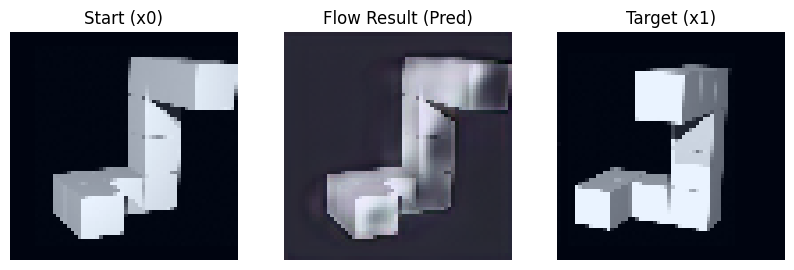

Epoch [10/100] Loss: 0.498991


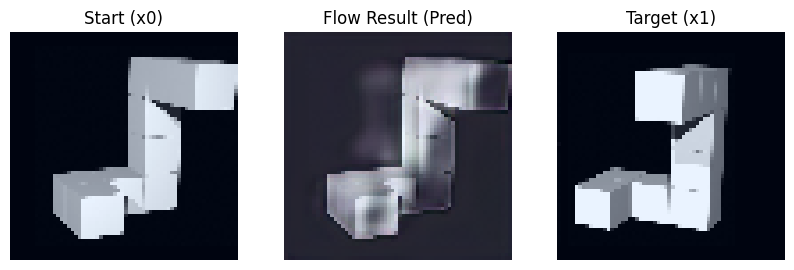

Epoch [15/100] Loss: 0.437688


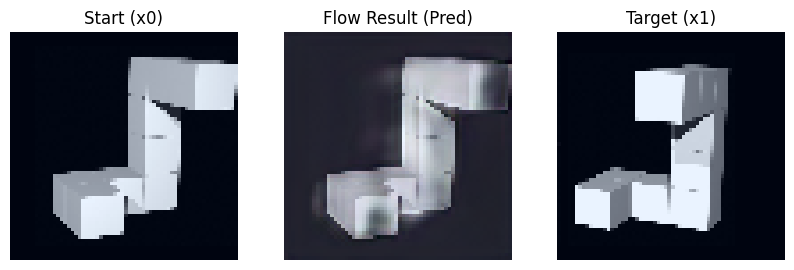

Epoch [20/100] Loss: 0.463682


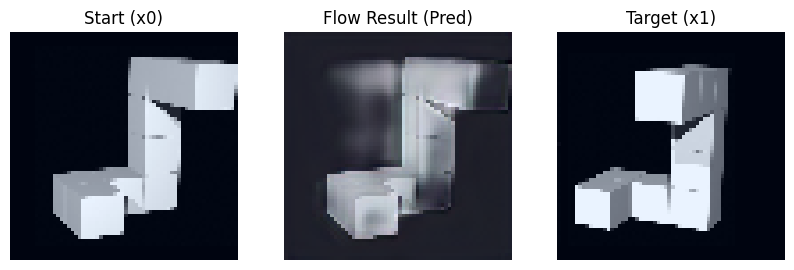

Epoch [25/100] Loss: 0.370772


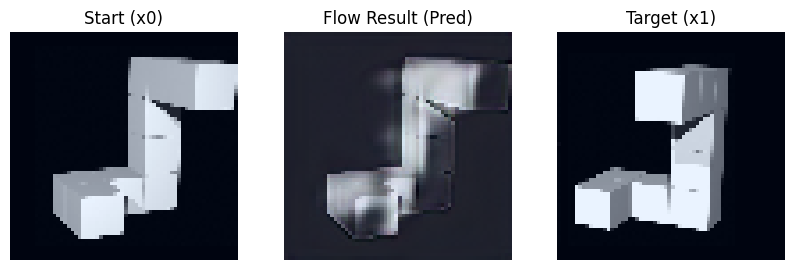

Epoch [30/100] Loss: 0.305050


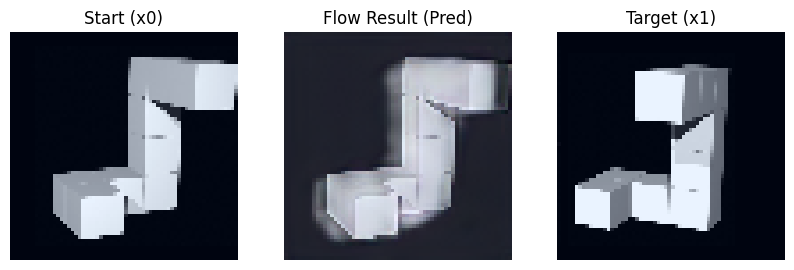

Epoch [35/100] Loss: 0.307444


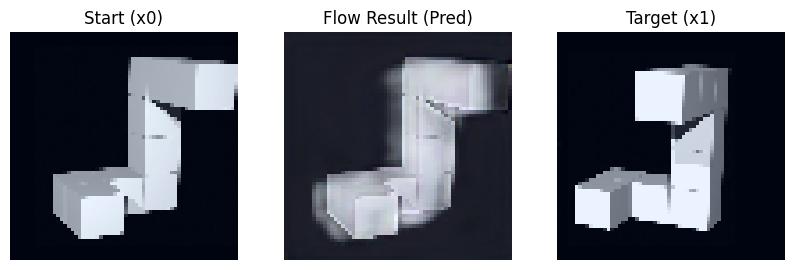

Epoch [40/100] Loss: 0.379755


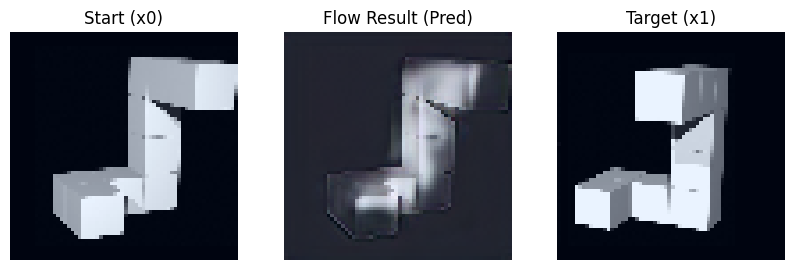

Epoch [45/100] Loss: 0.293494


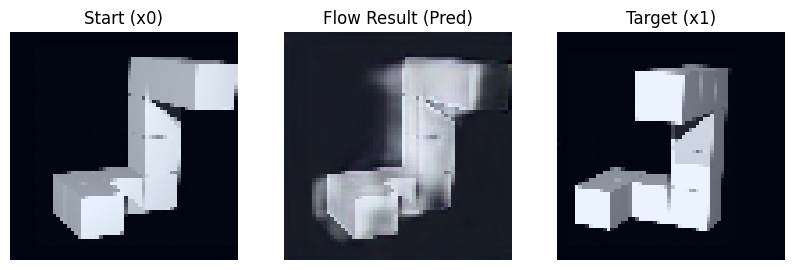

Epoch [50/100] Loss: 0.275241


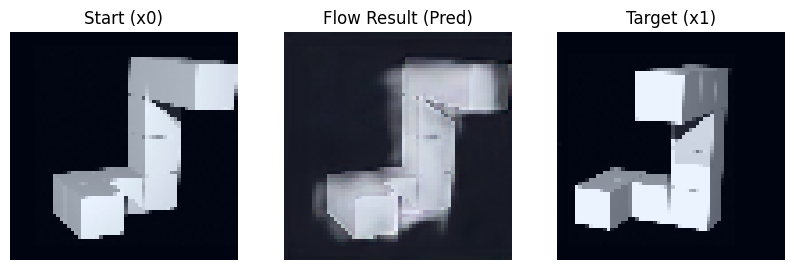

Epoch [55/100] Loss: 0.249865


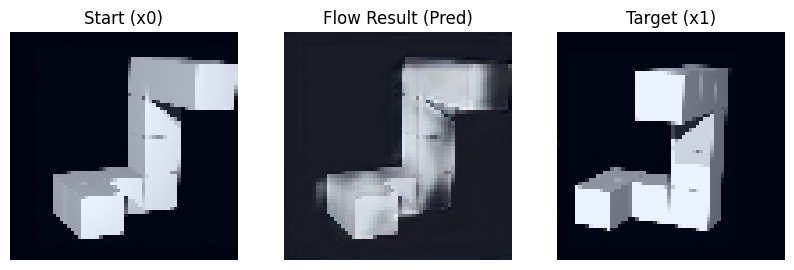

Epoch [60/100] Loss: 0.250850


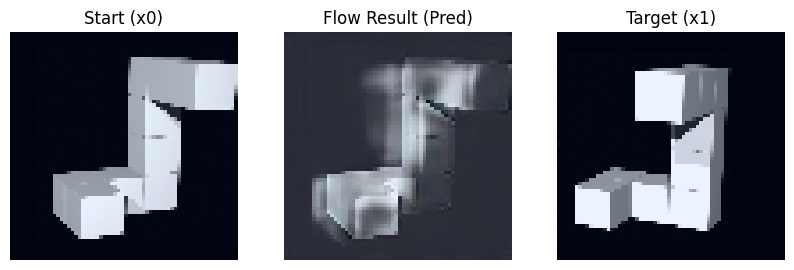

Epoch [65/100] Loss: 0.231705


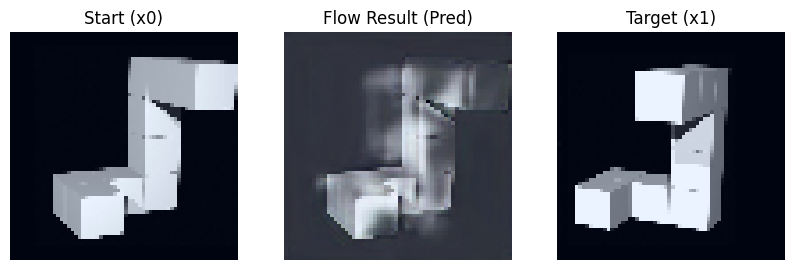

Epoch [70/100] Loss: 0.242258


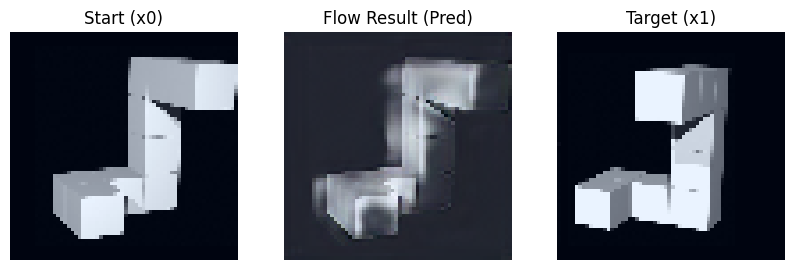

Epoch [75/100] Loss: 0.205513


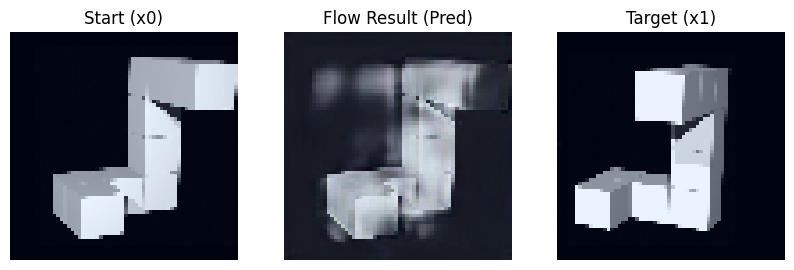

Epoch [80/100] Loss: 0.203805


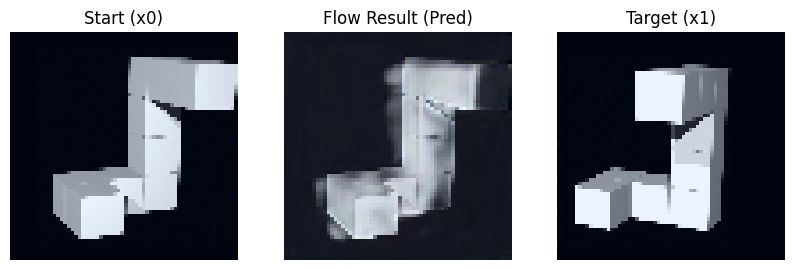

Epoch [85/100] Loss: 0.216954


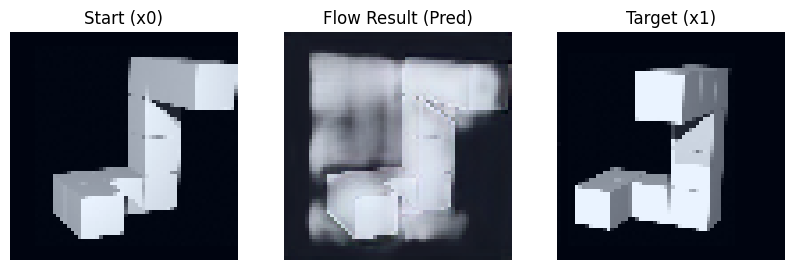

Epoch [90/100] Loss: 0.187744


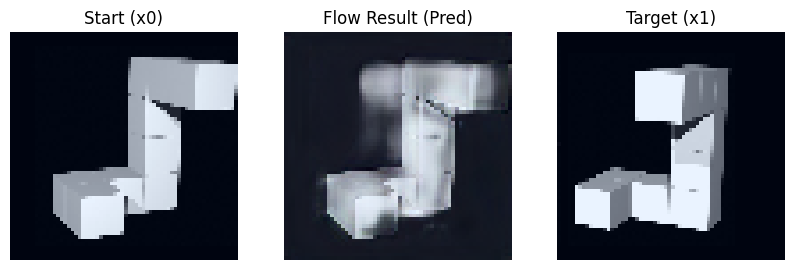

Epoch [95/100] Loss: 0.194844


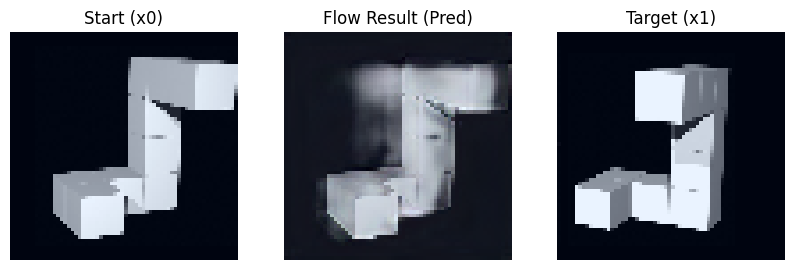

Epoch [100/100] Loss: 0.178762


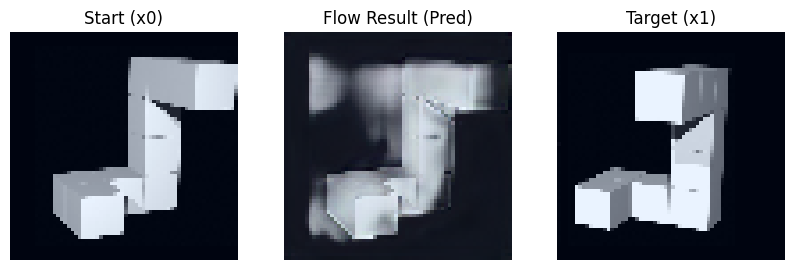

Training Complete.


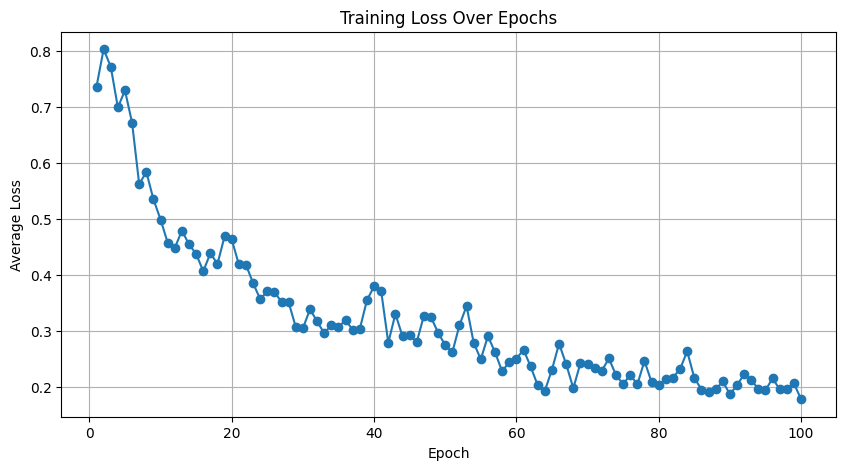

In [63]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.MSELoss()

EPOCHS = 100

# This "simulates" the flow physics to generate an image from x0
@torch.no_grad()
def solve_flow_euler(model, x_start, steps=10):
    """
    Physically moves pixels from x_start to x_end using the learned velocity.
    Uses Euler integration (dt = 1/steps).
    """
    model.eval()
    dt = 1.0 / steps
    current_x = x_start.clone()
    
    # Time flows from 0.0 to 1.0
    for i in range(steps):
        t_value = i / steps
        # Create time tensor of shape (Batch, 1)
        t = torch.full((x_start.shape[0], 1), t_value, device=x_start.device)
        
        # Predict velocity at current state
        velocity = model(current_x, t, x_start)
        
        # Move state: x_new = x_old + velocity * dt
        current_x = current_x + velocity * dt
        
    return current_x

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (x0, x1, _) in enumerate(train_loader):
        x0, x1 = x0.to(device), x1.to(device)
        batch_size = x0.shape[0]
        
        t = torch.rand(batch_size, 1, device=device)
        
        # x_t is the "noisy/mixed" state
        # Reshape t for broadcasting: (B, 1, 1, 1)
        t_view = t.view(batch_size, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        
        # The straight line direction from start to end
        target_velocity = x1 - x0
        
        # Predict velocity given state x_t, time t, and condition x0
        pred_velocity = model(x_t, t, x0)
        
        loss = criterion(pred_velocity, target_velocity)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.6f}")
        
        # Pick the first item from the test set to visualize progress
        sample_batch = next(iter(test_loader))
        # Filter for a 'same' pair for valid visualization
        same_indices = (sample_batch[2] == 1.0).nonzero(as_tuple=True)[0]
        if len(same_indices) > 0:
            idx = same_indices[0]
            vis_x0 = sample_batch[0][idx:idx+1].to(device)
            vis_x1 = sample_batch[1][idx:idx+1].to(device)
            
            # Run the Solver
            generated_x1 = solve_flow_euler(model, vis_x0, steps=20)
            
            fig, ax = plt.subplots(1, 3, figsize=(10, 3))
            
            # Helper to denormalize for display (approximate)
            def show_tens(ax, t, title):
                # Un-normalize (ImageNet stats) for display
                t = t.detach().cpu().squeeze().permute(1, 2, 0).numpy()
                t = (t - t.min()) / (t.max() - t.min())
                ax.imshow(t)
                ax.set_title(title)
                ax.axis('off')
                
            show_tens(ax[0], vis_x0, "Start (x0)")
            show_tens(ax[1], generated_x1, "Flow Result (Pred)")
            show_tens(ax[2], vis_x1, "Target (x1)")
            plt.show()

print("Training Complete.")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

Running Evaluation on Test Set...

--- Results ---
Mean Error (Same Pairs):      2.67859 (Should be LOW)
Mean Error (Diff Pairs):      3.23484 (Should be HIGH)


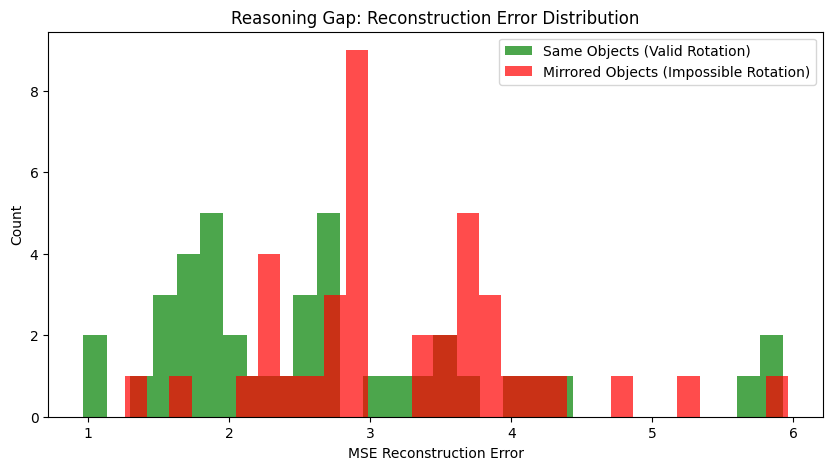

Reasoning AUC Score: 0.6923 (1.0 = Perfect Distinction)

Visualizing Examples...


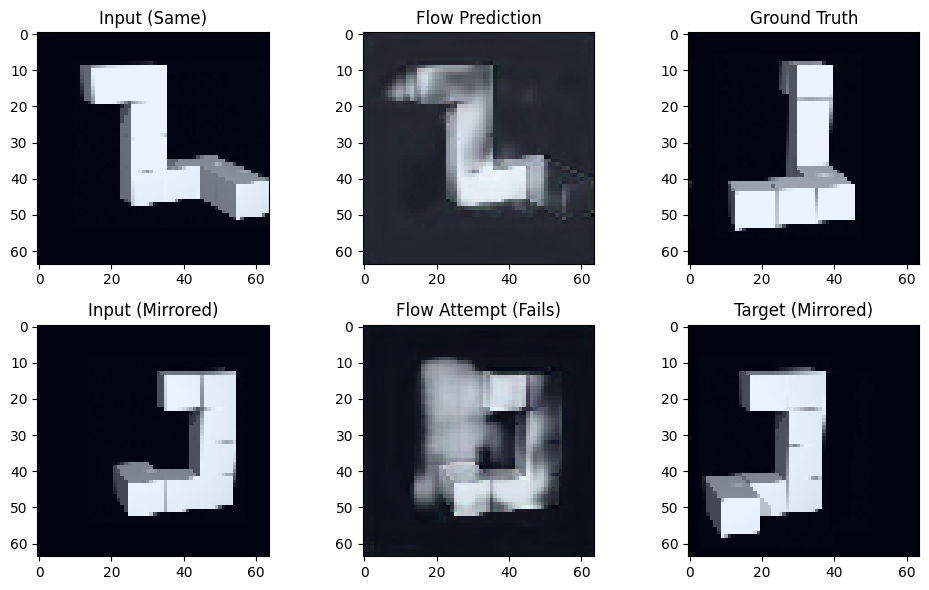

In [ ]:
# ODE solver
@torch.no_grad()
def solve_flow_batch(model, x_start, steps=10):
    """
    Generates x_end from x_start for an entire batch using Euler integration.
    """
    model.eval()
    dt = 1.0 / steps
    current_x = x_start.clone()
    batch_size = x_start.shape[0]
    device = x_start.device
    
    for i in range(steps):
        t_val = i / steps
        # Broadcast t to (B, 1)
        t = torch.full((batch_size, 1), t_val, device=device)
        
        # Get velocity field
        velocity = model(current_x, t, x_start)
        current_x = current_x + velocity * dt
        
    return current_x

errors_same = []
errors_diff = []

all_labels = []
all_errors = []

for batch_idx, (x0, x1, labels) in enumerate(test_loader):
    x0, x1 = x0.to(device), x1.to(device)
    
    # Generate prediction (10 reasoning steps)
    x_pred = solve_flow_batch(model, x0, steps=10)
    
    # Calculate Per-Sample MSE Error (Reconstruction Loss)
    # Shape: (B, 3, 64, 64) -> (B,)
    batch_errors = torch.mean((x_pred - x1)**2, dim=[1, 2, 3]).cpu().numpy()
    
    labels = labels.cpu().numpy()
    
    # Sort into buckets
    for i in range(len(labels)):
        err = batch_errors[i]
        lbl = labels[i]
        
        all_errors.append(err)
        all_labels.append(lbl)
        
        if lbl == 1.0: # Same
            errors_same.append(err)
        else: # Different
            errors_diff.append(err)

errors_same = np.array(errors_same)
errors_diff = np.array(errors_diff)

print(f"\n--- Results ---")
print(f"Mean Error (Same Pairs):      {np.mean(errors_same):.5f} (Should be LOW)")
print(f"Mean Error (Diff Pairs):      {np.mean(errors_diff):.5f} (Should be HIGH)")

# A. Visualizing the reasoning gap
plt.figure(figsize=(10, 5))
plt.hist(errors_same, bins=30, alpha=0.7, label='Same Objects (Valid Rotation)', color='green')
plt.hist(errors_diff, bins=30, alpha=0.7, label='Mirrored Objects (Impossible Rotation)', color='red')
plt.title("Reasoning Gap: Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

# Low error for prediction 1 (same), high error for prediction 0 (diff)
auc = roc_auc_score(all_labels, -np.array(all_errors)) 
print(f"Reasoning AUC Score: {auc:.4f}")

# Find best same and diff examples
same_indices = np.where(np.array(all_labels) == 1)[0]
diff_indices = np.where(np.array(all_labels) == 0)[0]

# Pick a random sample from each for display
idx_same = same_indices[0]
idx_diff = diff_indices[0]

print("\nVisualizing Examples...")
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

# Pick first item in last batch that was same
valid_mask = labels == 1.0
if valid_mask.any():
    idx = np.where(valid_mask)[0][0]
    
    # Show x0
    img = x0[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,0].imshow(img); ax[0,0].set_title("Input (Same)")
    
    # Show Prediction
    img = x_pred[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,1].imshow(img); ax[0,1].set_title("Flow Prediction")
    
    # Show Target
    img = x1[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,2].imshow(img); ax[0,2].set_title("Ground Truth")

# Pick first item in last batch that was diff
diff_mask = labels == 0.0
if diff_mask.any():
    idx = np.where(diff_mask)[0][0]
    
    img = x0[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,0].imshow(img); ax[1,0].set_title("Input (Mirrored)")
    
    img = x_pred[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,1].imshow(img); ax[1,1].set_title("Flow Attempt (Fails)")
    
    img = x1[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,2].imshow(img); ax[1,2].set_title("Target (Mirrored)")

plt.tight_layout()
plt.show()

In [66]:
# High res version
OUTPUT_SIZE = (224, 224) 
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 30

print("Loading and Upscaling Data...")
train_raw = np.load('./data/train_pairs.npy', allow_pickle=True)
test_raw = np.load('./data/test_balanced.npy', allow_pickle=True)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def prepare_data_highres(raw_list, is_train=False):
    x0_np = np.stack([d['x0'] for d in raw_list])
    x1_np = np.stack([d['x1'] for d in raw_list])
    
    x0_t = torch.tensor(x0_np).float()
    x1_t = torch.tensor(x1_np).float()
    
    # Upsample  to 224x224
    x0_t = F.interpolate(x0_t, size=OUTPUT_SIZE, mode='bilinear', align_corners=False)
    x1_t = F.interpolate(x1_t, size=OUTPUT_SIZE, mode='bilinear', align_corners=False)
    
    x0_t = x0_t.repeat(1, 3, 1, 1)
    x1_t = x1_t.repeat(1, 3, 1, 1)
    
    x0_t = (x0_t + 1) * 0.5 
    x1_t = (x1_t + 1) * 0.5
    
    normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x0_t = normalize(x0_t)
    x1_t = normalize(x1_t)
    
    if is_train:
        y = torch.ones(len(raw_list))
    else:
        y = torch.tensor([1.0 if d.get('label') == 'same' else 0.0 for d in raw_list])
        
    return x0_t, x1_t, y

train_x0, train_x1, train_y = prepare_data_highres(train_raw, is_train=True)
test_x0, test_x1, test_y = prepare_data_highres(test_raw, is_train=False)

train_loader = DataLoader(TensorDataset(train_x0, train_x1, train_y), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_x0, test_x1, test_y), batch_size=BATCH_SIZE)

# Reset weights
model = FlowReasoningModel(backbone=dinov3, backbone_dim=384, flow_dim=64)
model = model.to(device)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
criterion = nn.MSELoss()

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (x0, x1, _) in enumerate(train_loader):
        x0, x1 = x0.to(device), x1.to(device)
        curr_batch = x0.shape[0]
        
        t = torch.rand(curr_batch, 1, device=device)
        
        # Rectified flow interpolation
        t_view = t.view(curr_batch, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        
        target_velocity = x1 - x0
        
        pred_velocity = model(x_t, t, x0)
        
        loss = criterion(pred_velocity, target_velocity)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.6f}")


sample = next(iter(train_loader))
print(f"High-Res Input Shape: {sample[0].shape}") # Should be [16, 3, 224, 224]

Loading and Upscaling Data...
Initializing Model...
Starting High-Res Training on cpu...
Epoch [5/30] Loss: 1.715388
Epoch [10/30] Loss: 1.341870
Epoch [15/30] Loss: 1.247994
Epoch [20/30] Loss: 1.077004
Epoch [25/30] Loss: 0.931971
Epoch [30/30] Loss: 1.279303
Training Complete.
High-Res Input Shape: torch.Size([16, 3, 224, 224])



--- Results ---
Mean Error (Same Pairs):      2.82038 (Should be LOW)
Mean Error (Diff Pairs):      3.49452 (Should be HIGH)


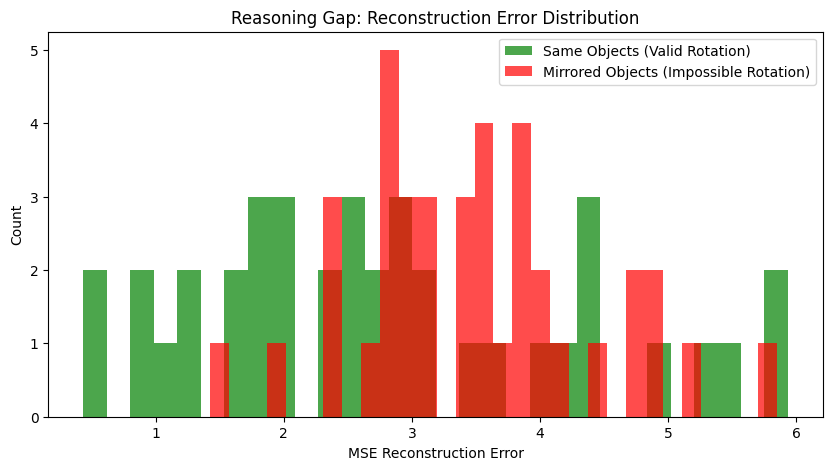

Reasoning AUC Score: 0.6680

Visualizing Examples...


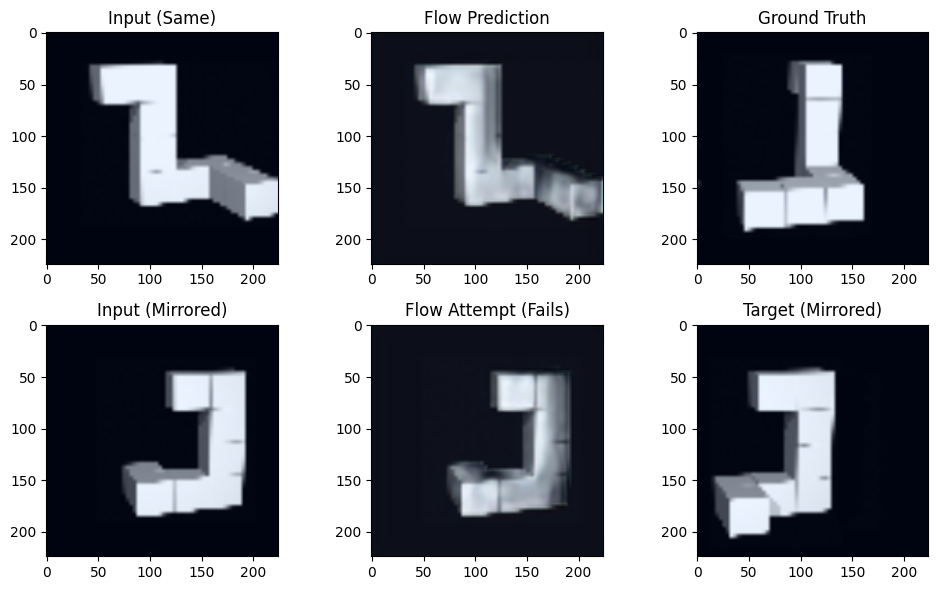

In [67]:
errors_same = []
errors_diff = []

all_labels = []
all_errors = []

for batch_idx, (x0, x1, labels) in enumerate(test_loader):
    x0, x1 = x0.to(device), x1.to(device)
    
    # Generate prediction (10 reasoning steps)
    x_pred = solve_flow_batch(model, x0, steps=10)
    
    # Calculate Per-Sample MSE Error (Reconstruction Loss)
    # Shape: (B, 3, 64, 64) -> (B,)
    batch_errors = torch.mean((x_pred - x1)**2, dim=[1, 2, 3]).cpu().numpy()
    
    labels = labels.cpu().numpy()
    
    # Sort into buckets
    for i in range(len(labels)):
        err = batch_errors[i]
        lbl = labels[i]
        
        all_errors.append(err)
        all_labels.append(lbl)
        
        if lbl == 1.0: # Same
            errors_same.append(err)
        else: # Different
            errors_diff.append(err)

errors_same = np.array(errors_same)
errors_diff = np.array(errors_diff)

print(f"\n--- Results ---")
print(f"Mean Error (Same Pairs):      {np.mean(errors_same):.5f} (Should be LOW)")
print(f"Mean Error (Diff Pairs):      {np.mean(errors_diff):.5f} (Should be HIGH)")

# A. Visualizing the reasoning gap
plt.figure(figsize=(10, 5))
plt.hist(errors_same, bins=30, alpha=0.7, label='Same Objects (Valid Rotation)', color='green')
plt.hist(errors_diff, bins=30, alpha=0.7, label='Mirrored Objects (Impossible Rotation)', color='red')
plt.title("Reasoning Gap: Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

# Low error for prediction 1 (same), high error for prediction 0 (diff)
auc = roc_auc_score(all_labels, -np.array(all_errors)) 
print(f"Reasoning AUC Score: {auc:.4f}")

# Find best same and diff examples
same_indices = np.where(np.array(all_labels) == 1)[0]
diff_indices = np.where(np.array(all_labels) == 0)[0]

# Pick a random sample from each for display
idx_same = same_indices[0]
idx_diff = diff_indices[0]

print("\nVisualizing Examples...")
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

# Pick first item in last batch that was same
valid_mask = labels == 1.0
if valid_mask.any():
    idx = np.where(valid_mask)[0][0]
    
    # Show x0
    img = x0[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,0].imshow(img); ax[0,0].set_title("Input (Same)")
    
    # Show Prediction
    img = x_pred[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,1].imshow(img); ax[0,1].set_title("Flow Prediction")
    
    # Show Target
    img = x1[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[0,2].imshow(img); ax[0,2].set_title("Ground Truth")

# Pick first item in last batch that was diff
diff_mask = labels == 0.0
if diff_mask.any():
    idx = np.where(diff_mask)[0][0]
    
    img = x0[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,0].imshow(img); ax[1,0].set_title("Input (Mirrored)")
    
    img = x_pred[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,1].imshow(img); ax[1,1].set_title("Flow Attempt (Fails)")
    
    img = x1[idx].detach().cpu().permute(1,2,0).numpy(); img=(img-img.min())/(img.max()-img.min())
    ax[1,2].imshow(img); ax[1,2].set_title("Target (Mirrored)")

plt.tight_layout()
plt.show()